# Part 1: Getting Started with Basic Functions

## Introduction

#### **Purpose**


The purpose of this demo is to showcase the utility of some common data exploration methods using the OpenDP Context API with the Polars Integration. The notebook will focus on statistical releases in the *trusted curator* setting.

Throughout this notebook, we will make statistical queries to data with and without privacy-preserving mechanisms. As we compare query results side-by-side, we show that conclusions about the data are similar in both settings: without privacy-preserving mechanism, and with differential privacy mechanism. Let's get started! 

To learn more about the dataset itself, check out the Pre-Processing Notebook.



In [1]:
pip install numpy matplotlib seaborn polars


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "opendp[polars]"


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import libraries 
import numpy as np 
import polars as pl 
import opendp.prelude as dp
# import "opendp[polars]" as dp
dp.enable_features("contrib")
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme(style='darkgrid')

In [4]:
# reading in the data
df = pl.scan_csv("FR_LFS_2008Q1.csv", infer_schema_length=1000, ignore_errors=True)

The dataset is from the 2008 Quarter 1 Labor Force Survey from Eurostat. Each individual is represented at most once. 

## Defining the Compositor

First up, we will define the compositer. The compositer is the foundation of our differentially private queries. It essentially takes in our data and our specifications for the queries that we would like to run. At this point, we won't be directly referencing our data again and we could theoretically delete it! 

**Parameters**:
- *privacy_unit:* This is how many rows each individual or entity of interest contributes to our dataframe. In this case, we are analyzing the data from the first quarter of 2008 and each individual is represented once, so the privacy unit will be 1. If we were to analyze the dataset across quarters and years, then each individual would contribute (number of quarters * number of years) times. 

- *privacy_loss:* This parameter determines how much privacy we want to preserve. If epsilon is small, then we will have more privacy but worse data accuracy. Epsilon can range from 0 to infinity, but 1 usually a standard. 

- *split_evenly_over:* This is the number of queries you want to distribute your privacy loss over. 

- *margins:* Margins captures the variables of interest in your analysis. This can include variables that you may want to group by or apply differential privacy techniques to. 
    - *public_info:* There are two options here: keys and lengths. 
        - *keys:* The variables that you are grouping by are public. 
        - *lengths:* The variables that you are grouping by and the corresponding aggregrate statistics are public. 
    - *max_partition_length:* The upper bound on how many records (individuals in this case) can be in one partition. This is generally an upper bound on the population represented in your dataset if you do not know the size of your dataset. In this case, the population of France was about 60 million in 2004 so that's our maximium partition length. Source: [World Bank](https://datatopics.worldbank.org/world-development-indicators/). 

In [5]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=1,
    margins={
        ("SEX", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("HWUSUAL", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

## Group By

Let's get the count of each gender category and compare the differentially private values to the actual values. 

First, we will create the query for the actual count values of each gender. 

This step is valuable since a lot of the syntax will remain the same when we apply the differential privacy mechanism.

In [6]:
#define categories for gender
gender_cat = ['Male', 'Female']
#create query for actual count values
actual_count_values = list((df.group_by("SEX").agg(pl.len())).sort("SEX").collect()['len'])


Now to get the differentially private statistics, add "dp.noise" after the aggregrate function is specified and ".release" after the entire query before ".collect." 

Calling ".release" is always the final step in compiling your differentially private data in a usable form and ensuring its compliant with differential privacy guarantees. 

In [7]:
dp_count_values = list((context.query().group_by("SEX").agg(pl.len().dp.noise())).release().collect()['len'])

We can visualize these results in a histogram. 

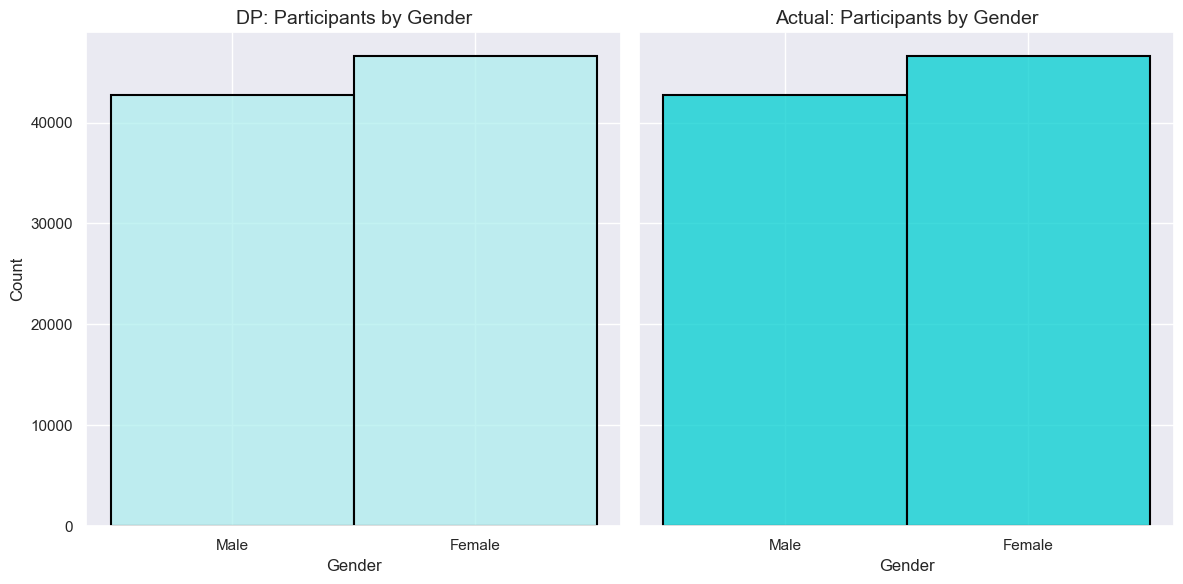

In [8]:
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.histplot(x=gender_cat, weights=dp_count_values, ax=axs[0], color='paleturquoise', edgecolor='black', linewidth=1.5)
axs[0].set_title("DP: Participants by Gender", fontsize=14)
axs[0].set_xlabel("Gender", fontsize=12)
axs[0].set_ylabel("Count", fontsize=12)

sns.histplot(x=gender_cat, weights=actual_count_values, ax=axs[1], color='darkturquoise', edgecolor='black', linewidth=1.5)
axs[1].set_title("Actual: Participants by Gender", fontsize=14)
axs[1].set_xlabel("Gender", fontsize=12)
axs[1].set_ylabel("Count", fontsize=12)
plt.tight_layout()

In both the actual and differentially private data, the counts per gender category are similar!

## Group By Multiple Variables

### Redefining the Compositor

Usually you'll be analyzing data with multiple variables involved across time. So let's bring in another dataset sampled 5000 entries across all years (2004-2013) in the full dataset. Since each individual can now be present multiple times in this dataset, we will need to redefine the compositer to reflect this.

In [9]:
df = pl.scan_csv("sample_FR_LFS.csv", infer_schema_length=1000, ignore_errors=True)

If the "sample_FR_LFS.csv" file exists, then follow the code for importing the dataset as is. Otherwise follow the instructions from Preprocessing.ipynb to download and compile the dataset for these notebooks.

In [10]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10,
    margins={
        ("SEX", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("AGE", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("ILOSTAT", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("HWUSUAL", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("YEAR", ): dp.Margin(public_info="keys", max_partition_length=60_000_000, max_partition_contributions=4),
        ("QUARTER", ): dp.Margin(public_info="keys", max_partition_length=60_000_000, max_partition_contributions=13),
        ("YEAR", "QUARTER",): dp.Margin(public_info="keys", max_partition_length=60_000_000, max_partition_contributions=1),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

Here is how this compositer is different from the one we defined previously: 

1. Privacy Unit: 


Prevously, we analyzed one particular quarter in one year of the dataset where each individual was represented only once, meaning their contribution to the dataset was 1. In this new data and context, we explore each individual across 4 quarters in 9 years from 2004 to 2013, leading to 36 contributions. Even if you know that some individuals were not sampled consistently for all 9 years, use the upper bound of 36 anyway. 

2. Split Evenly Over: 

The number of queries that we will run using this context has changed from X to X. 

3. Margins


We include some more variables that we are interested in computing statistics for, such as "YEAR", 
"QUARTER", "ILOSTAT" (which is the labour status during the reference week) and variables sets that we will use for grouping by multiple variables such as "YEAR" and "QUARTER". 

Notice that we defined the parameter max_partition_contributions for the ("YEAR"), ("QUARTER"), and ("YEAR","QUARTER") margins. The max_partition_contributions is 4 for ("YEAR") since each individual can appear at most 4 times per each year. Similarily, the max_partition_contributions is 13 for ("QUARTER") since each individual can appear at most 13 times per quarter across this dataset. It is 1 for ("YEAR", "QUARTER") since each individual appears once per quarter per year. 

### Multiple Variable Group By Query

Defining the multiple variables you want to group by in the margin was the hard part. Asides from the grouping variables, the multiple variable group by query is identical to the singular variable group by query.

Let's take look at how many individuals are represented in each quarter and year in the dataset.

In [11]:
#compute dp values
mgb_dp_values = (context.query().group_by(["YEAR","QUARTER"]).agg(pl.len().dp.noise().alias("DP"))).sort(["YEAR","QUARTER"]).release().collect()
#compute actual values
mgb_tr_values = (df.group_by(["YEAR","QUARTER"]).agg(pl.len().alias("Actual"))).sort(["YEAR","QUARTER"]).collect()
#get merged df
yq_df = mgb_dp_values.join(mgb_tr_values, on=['YEAR', 'QUARTER'])
yq_df

YEAR,QUARTER,DP,Actual
i64,i64,u32,u32
2004,1,10596,10523
2004,2,9974,10629
2004,3,10383,10204
2004,4,10684,10469
2005,1,10530,10379
…,…,…,…
2012,4,16111,15859
2013,1,15422,15447
2013,2,14871,14748


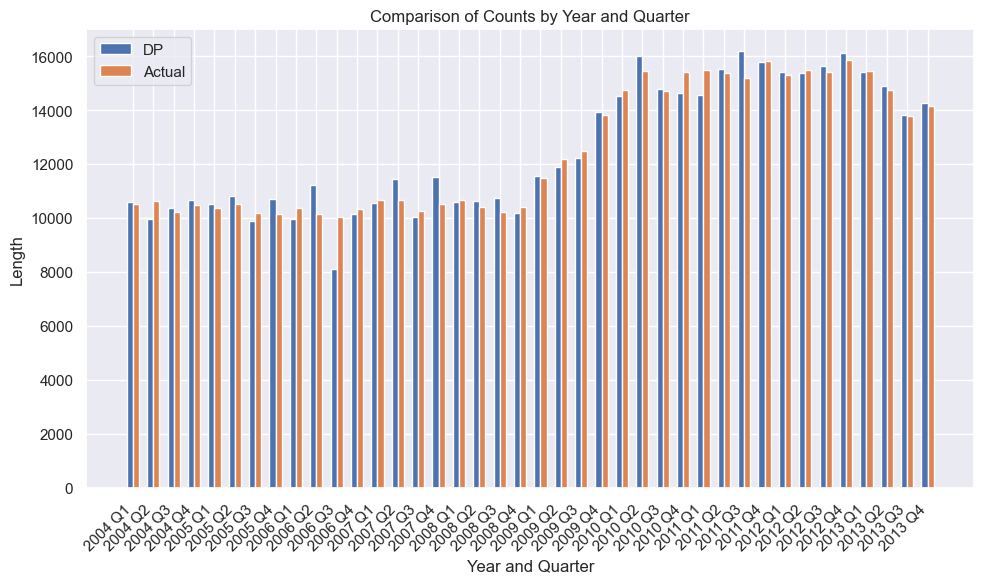

In [12]:
yq_df.sort(by=['YEAR', 'QUARTER'])
labels = [f"{year} Q{quarter}" for year, quarter in zip(yq_df['YEAR'], yq_df['QUARTER'])]
x = np.arange(len(labels))  

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 0.3/2, yq_df['DP'], 0.3, label='DP')
bars2 = ax.bar(x + 0.3/2, yq_df['Actual'], 0.3, label='Actual')

ax.set_xlabel('Year and Quarter')
ax.set_ylabel('Length')
ax.set_title('Comparison of Counts by Year and Quarter')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


## Filtering and Time Series

Now let's incorporate some filtering into our analysis by seeing if the number of people seeking employment during the previous four weeks at the time of study changes. 

*Note: The labor status 3 represents "Was not working because on lay-off."

In [13]:
year_dp = (
        #define the query
        context.query().
        #filter for labour status 
        filter(pl.col("ILOSTAT")==3).
        #group by each year
        group_by("YEAR").
        #get the count and apply noise 
        agg([pl.len().dp.noise().alias("count")]).
        #sort by year
        sort("YEAR")
        #collect your lazydataframe and sort it by year
        ).release().collect().sort("YEAR")

year_actual = df.filter((pl.col("ILOSTAT")==3)).groupby("YEAR").agg(pl.col("YEAR").count().alias("count")).sort("YEAR").collect()

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_6314/4101804306.py:15: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  year_actual = df.filter((pl.col("ILOSTAT")==3)).groupby("YEAR").agg(pl.col("YEAR").count().alias("count")).sort("YEAR").collect()


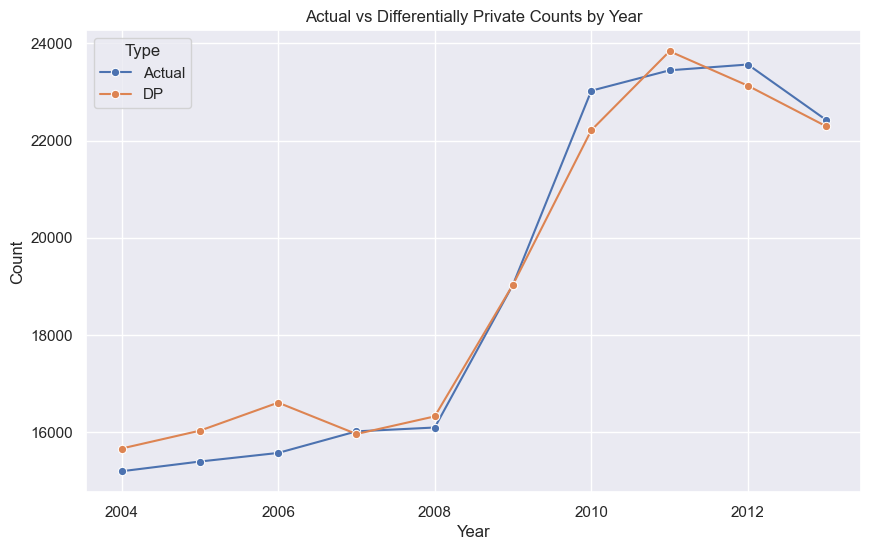

In [14]:
year_actual_pd = year_actual.to_pandas()
year_dp_pd = year_dp.to_pandas()
year_actual_pd['type'],year_dp_pd['type']  = 'Actual', 'DP'

all_year_df = pl.concat([pl.from_pandas(year_actual_pd), pl.from_pandas(year_dp_pd)]).to_pandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=all_year_df, x="YEAR", y="count", hue="type", marker="o")
plt.title('Actual vs Differentially Private Counts by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

It appears that the trend of number of people seeking employment from 2004 to 2013 was consistent across the actual values and the differentially private values. 

## Conclusion

In this notebook, we covered some basic DP operations such as applying noise directly to a variable and how you could use common data manipulation techniques such a grouping, filtering, and visualization with DP data. 

This tutorial was an interactive walk through of applying DP mechanisms. When applying such techniques in a real-world setting, you would create your plan and queries with interactively, but you wouldn’t tweak any of your code when producing your differentially private results. 

If you have any ideas on how to improve this notebook or specific content you'd like to see in future notebooks, let us know here! 